In [1]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

# Analyze Facebook Data Using IBM Watson and IBM Data Platform

This is a three-part notebook written in `Python_3.5` meant to show how anyone can enrich and analyze a combined dataset of unstructured and structured information with IBM Watson and IBM Data Platform. For this example we are using a standard Facebook Analytics export which features texts from posts, articles and thumbnails, along with standard performance metrics such as likes, shares, and impressions. 

**Part I** will use the Natual Language Understanding, Visual Recognition and Tone Analyzer Services from IBM Watson to enrich the Facebook Posts, Thumbnails, and Articles by pulling out `Emotion Tones`, `Social Tones`, `Language Tones`, `Entities`, `Keywords`, and `Document Sentiment`. The end result of Part I will be additional features and metrics we can test, analyze, and visualize in Part III. 

**Part II** will be used to set up the visualizations and tests we will run in Part III. The end result of Part II will be multiple pandas DataFrames that will contain the values, and metrics needed to find insights from the Part III tests and experiments.

**Part III** will include services from IBM's Data Platform, including IBM's own data visualization library PixieDust. In Part III we will run analysis on the data from the Facebook Analytics export, such as the number of likes, comments, shares, to the overall reach for each post, and will compare it to the enriched data we pulled in Part I.


#### You should only need to change data in the Setup portion of this notebook. All places where you see  <span style="color: red"> User Input </span> is where you should be adding inputs. 

### Table of Contents

### [**Part I - Enrich**](#part1)<br>
1. [Setup](#setup)<br>
   1.1 [Install Watson Developer Cloud and BeautifulSoup Packages](#setup1)<br>
   1.2 [Install PixieDust](#pixie)<br> 
   1.3 [Restart Kernel](#restart)<br> 
   1.4 [Import Packages and Libraries](#setup2)<br>
   1.5 [Add Service Credentials From IBM Cloud for Watson Services](#setup3)<br>
2. [Load Data](#load)<br>
   2.1 [Load Data From SoftLayer's Object Storage as a Pandas DataFrame](#load1)<br>
3. [Prepare Data](#prepare)<br>
   3.1 [Data Cleansing with Python](#prepare1)<br>
   3.2 [Beautiful Soup to Extract Thumbnails and Extented Links](#prepare2)<br>
4. [Enrich Data](#enrich)<br>
   4.1 [NLU for Post Text](#nlupost)<br>
   4.2 [NLU for Thumbnail Text](#nlutn)<br>
   4.3 [NLU for Article Text](#nlulink)<br>
   4.4 [Tone Analyzer for Post Text](#tonepost)<br>
   4.5 [Tone Analyzer for Article Text](#tonearticle)<br>
   4.6 [Visual Recognition](#visual)<br>
5. [Write Data](#write)<br>
   5.1 [Convert DataFrame to new CSV](#write1)<br>
   5.2 [Write Data to SoftLayer's Object Storage](#write2)<br>
    
### [**Part II - Data Preparation**](#part2)<br>
1. [Prepare Data](#prepare)<br>
   1.1 [Create Multiple DataFrames for Visualizations](#visualizations)<br>
   1.2 [Create a Consolidated Tone DataFrame](#tone)<br>
   1.3 [Create a Consolidated Keyword DataFrame](#keyword)<br>
   1.4 [Create a Consolidated Entity DataFrame](#entity)<br>
  
### [**Part III - Analyze**](#part3)<br>

1. [Setup](#2setup)<br> 
    1.1 [Assign Variables](#2setup2)<br>
2. [Visualize Data](#2visual)<br>
    2.1 [Run PixieDust Visualization Library with Display() API](#2visual1)
   
### Learn more about the technology used:

* [Natual Language Understanding](https://www.ibm.com/watson/developercloud/natural-language-understanding.html)
* [Tone Analyzer](https://www.ibm.com/watson/developercloud/tone-analyzer.html)
* [Visual Recognition](https://www.ibm.com/watson/services/visual-recognition/)
* [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [PixieDust](https://github.com/ibm-cds-labs/pixiedust) (Part III)

### Sample Documents
[Sample Facebook Posts](https://github.com/IBM/pixiedust-facebook-analysis/blob/master/data/example_input/example_facebook_data.csv) - This is a sample export of IBM Watson's Facebook Page. Engagement metrics such as clicks, impressions, etc. are all changed and do not reflect any actual post performance data.


<a id="part1"></a>
#  Part I - Enrich

<a id="setup"></a>
## 1. Setup
<a id="setup1"></a>
### 1.1 Install Latest Watson Developer Cloud and Beautiful Soup Packages

In [2]:
!pip install --upgrade watson-developer-cloud==1.0.1

Requirement already up-to-date: watson-developer-cloud==1.0.1 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages
Requirement already up-to-date: python-dateutil>=2.5.3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from watson-developer-cloud==1.0.1)
Requirement already up-to-date: pysolr<4.0,>=3.3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from watson-developer-cloud==1.0.1)
Requirement already up-to-date: requests<3.0,>=2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from watson-developer-cloud==1.0.1)
Requirement already up-to-date: pyOpenSSL>=16.2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from watson-developer-cloud==1.0.1)


In [3]:
!pip install --upgrade beautifulsoup4

Requirement already up-to-date: beautifulsoup4 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages


<a id="pixie"></a>
### 1.2 Install PixieDust Library
This notebook provides an overview of how to use the PixieDust library to analyze and visualize various data sets. If you are new to PixieDust or would like to learn more about the library, please go to this [Introductory Notebook](https://apsportal.ibm.com/exchange/public/entry/view/5b000ed5abda694232eb5be84c3dd7c1) or visit the [PixieDust Github](https://ibm-cds-labs.github.io/pixiedust/). The `Setup` section for this notebook uses instructions from the [Intro To PixieDust](https://github.com/ibm-cds-labs/pixiedust/blob/master/notebook/Intro%20to%20PixieDust.ipynb) notebook.

Ensure you are running the latest version of PixieDust by running the following cell. Do not run this cell if you installed PixieDust locally from source and want to continue to run PixieDust from source.

In [4]:
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbba-ea23373a6e8935-79175279034c/.local/lib/python3.5/site-packages (from pixiedust)


<a id="restart"></a>
### 1.3 Restart Kernel
> Required after installs/upgrades only.

If any libraries were just installed or upgraded, <span style="color: red">restart the kernel</span> before continuing. After this has been done once, you might want to comment out the `!pip install` lines above for cleaner output and a faster "Run All".

<a id="setup2"></a>
### 1.4 Import Packages and Libraries
> Tip: To check if you have a package installed, open a new cell and write: `help(<package-name>)`.

In [5]:
import json
import sys

import watson_developer_cloud
from watson_developer_cloud import ToneAnalyzerV3, VisualRecognitionV3
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, EmotionOptions, SentimentOptions

import operator
from functools import reduce
from io import StringIO
import numpy as np
from bs4 import BeautifulSoup as bs
from operator import itemgetter
from os.path import join, dirname
import pandas as pd
import numpy as np
import requests
import pixiedust

# Suppress some pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

Pixiedust database opened successfully


<a id='setup3'></a>
### 1.5 Add Service Credentials From IBM Cloud for Watson Services
Edit the following cell to provide your credentials for Watson Visual Recognition, Natural Language Understanding and Tone Analyzer.

###  <span style="color: red"> _User Input_</span> 

In [6]:
# @hidden_cell

# Watson Visual Recognition
VISUAL_RECOGNITION_API_KEY =

# Watson Natural Launguage Understanding (NLU)
NATURAL_LANGUAGE_UNDERSTANDING_USERNAME =
NATURAL_LANGUAGE_UNDERSTANDING_PASSWORD =

# Watson Tone Analyzer
TONE_ANALYZER_USERNAME =
TONE_ANALYZER_PASSWORD =

In [7]:
# Create the Watson clients

nlu = watson_developer_cloud.NaturalLanguageUnderstandingV1(version='2017-02-27',
                                                            username=NATURAL_LANGUAGE_UNDERSTANDING_USERNAME,
                                                            password=NATURAL_LANGUAGE_UNDERSTANDING_PASSWORD)
tone_analyzer = ToneAnalyzerV3(version='2016-05-19',
                               username=TONE_ANALYZER_USERNAME,
                               password=TONE_ANALYZER_PASSWORD)

visual_recognition = VisualRecognitionV3('2016-05-20', api_key=VISUAL_RECOGNITION_API_KEY)

<a id='load'></a> 
## 2. Load Data

### 2.1 Load data from Object Storage

**Select the cell below and place your cursor on an empty line below the comment.** Load the CSV file you want to enrich by clicking on the 10/01 icon (upper right), then click `Insert to code` under the file you want to enrich, and choose `Insert Pandas DataFrame`.

###  <span style="color: red"> _User Input_</span> 

In [8]:
# insert pandas DataFrame

,Post ID,Permalink,Post Message,Type,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,...,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative feedback - unlike_page_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lifetime: The total number of people your Page...,Lifetime: The number of people who saw your Pa...,...,NaN,Lifetime: The number of clicks anywhere in you...,NaN,NaN,Lifetime: The number of people who have given ...,NaN,NaN,Lifetime: The number of times people have give...,NaN,NaN
1,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Cheers to a wonderful New Year with Chef Watso...,Photo,NaN,NaN,12/31/15 6:28,,2291,2291,...,4.0,21,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,IBM Watson's cover photo,Photo,NaN,NaN,12/31/15 6:26,,158,158,...,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,NaN,NaN
3,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,What is Watson? IBM Watson is a technology pla...,Photo,NaN,NaN,12/30/15 7:00,,4203,4203,...,67.0,26,102.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
4,187446750783_10153355476175784,https://www.facebook.com/ibmwatson/posts/10153...,"Your new personal shopping assistant, with the...",Link,NaN,NaN,12/29/15 6:26,,3996,3996,...,NaN,44,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Make sure this uses the variable above. The number will vary in the inserted code.
try:
    df = df_data_1
except NameError as e:
    print('Error: Setup is incorrect or incomplete.\n')
    print('Follow the instructions to insert the pandas DataFrame above, and edit to')
    print('make the generated df_data_# variable match the variable used here.')
    raise

**Select the cell below and place your cursor on an empty line below the comment.** 
Put in the credentials for the file you want to enrich by clicking on the 10/01 (upper right), then click `Insert to code` under the file you want to enrich, and choose `Insert Credentials`.

**Change the inserted variable name to `credentials_1`**

###  <span style="color: red"> _User Input_</span> 

In [10]:
#insert credentials for file - Change to credentials_1
# @hidden_cell

In [11]:
# Make sure this uses the variable above. The number will vary in the inserted code.
try:
    credentials = credentials_1
except NameError as e:
    print('Error: Setup is incorrect or incomplete.\n')
    print('Follow the instructions to insert the file credentials above, and edit to')
    print('make the generated credentials_# variable match the variable used here.')
    raise

<a id='prepare'></a>
## 3. Prepare Data



<a id='prepare1'></a>
###  3.1 Data Cleansing with Python
Renaming columns, removing noticeable noise in the data, pulling out URLs and appending to a new column to run through NLU.

In [12]:
df.rename(columns={'Post Message': 'Text'}, inplace=True)

In [13]:
# Drop the rows that have NaN for the text.
df.dropna(subset=['Text'], inplace=True)

In [14]:
df_http = df["Text"].str.partition("http")
df_www = df["Text"].str.partition("www")

# Combine delimiters with actual links
df_http["Link"] = df_http[1].map(str) + df_http[2]
df_www["Link1"] = df_www[1].map(str) + df_www[2]

# Include only Link columns
df_http.drop(df_http.columns[0:3], axis=1, inplace = True)
df_www.drop(df_www.columns[0:3], axis=1, inplace = True)

# Merge http and www DataFrames
dfmerge = pd.concat([df_http, df_www], axis=1)

# The following steps will allow you to merge data columns from the left to the right
dfmerge = dfmerge.apply(lambda x: x.str.strip()).replace('', np.nan)

# Use fillna to fill any blanks with the Link1 column
dfmerge["Link"].fillna(dfmerge["Link1"], inplace = True)

# Delete Link1 (www column)
dfmerge.drop("Link1", axis=1, inplace = True)

# Combine Link data frame
df = pd.concat([dfmerge,df], axis = 1)

# Make sure text column is a string
df["Text"] = df["Text"].astype("str")

# Strip links from Text column
df['Text'] = df['Text'].apply(lambda x: x.split('http')[0])
df['Text'] = df['Text'].apply(lambda x: x.split('www')[0])

Pull thumbnail descriptions and image URLs using requests and beautiful soup.

In [15]:
# Change links from objects to strings
for link in df.Link:
    df.Link.to_string()

piclinks = []
description = []
for url in df["Link"]:
    if pd.isnull(url):
        piclinks.append("")
        description.append("")
        continue
        
    try:
        page3 = requests.get(url)
        if page3.status_code != requests.codes.ok:
            piclinks.append("")
            description.append("")
            continue
    except Exception as e:
        print("Skipping url %s: %s" % (url, e))
        piclinks.append("")
        description.append("")
        continue
        
    soup3 = bs(page3.text,"lxml")
    
    pic = soup3.find('meta', property ="og:image")
    if pic:
        piclinks.append(pic["content"])
    else: 
        piclinks.append("")
    
    content = None
    desc = soup3.find(attrs={'name':'Description'})
    if desc:
        content = desc['content']
    if not content or content == 'null':
        # Try again with lowercase description
        desc = soup3.find(attrs={'name':'description'})
        if desc:
            content = desc['content']
    if not content or content == 'null':
        description.append("")
    else:
        description.append(content)
            
# Save thumbnail descriptions to df in a column titled 'Thumbnails'
df["Thumbnails"] = description
# Save image links to df in a column titled 'Image'
df["Image"] = piclinks

Skipping url http://ibm.co/fb_1IULX2R: HTTPSConnectionPool(host='community.watsonanalytics.com', port=443): Max retries exceeded with url: /watson-analytics-just-got-more-socially-savvy/ (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe6cea76080>: Failed to establish a new connection: [Errno 110] Connection timed out',))
Skipping url http://ibm.co/1VdSQDU: HTTPSConnectionPool(host='www.ibmchefwatson.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))
Skipping url http://ibm.co/1VdSQDU: HTTPSConnectionPool(host='www.ibmchefwatson.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))


Convert shortened links to full links.
Use requests module to pull extended links. This is only necessary if the Facebook page uses different links than the articles themselves. For this example we are using IBM Watson's Facebook export which uses an IBM link. 


In [16]:
shortlink = df["Link"]
extendedlink = []

for link in shortlink:
    if isinstance(link, float):  # Float is not a URL, probably NaN.
        extendedlink.append('')
    else:
        try:
            extended_link = requests.Session().head(link, allow_redirects=True).url
            extendedlink.append(extended_link)
        except Exception as e:
            print("Skipping link %s: %s" % (link, e))
            extendedlink.append('')

df["Extended Links"] = extendedlink

Skipping link http://ibm.co/fb_1IULX2R: HTTPSConnectionPool(host='community.watsonanalytics.com', port=443): Max retries exceeded with url: /watson-analytics-just-got-more-socially-savvy/ (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe6ce2c04a8>: Failed to establish a new connection: [Errno 110] Connection timed out',))
Skipping link http://ibm.co/1VdSQDU: HTTPSConnectionPool(host='www.ibmchefwatson.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))
Skipping link http://ibm.co/1VdSQDU: HTTPSConnectionPool(host='www.ibmchefwatson.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))


<a id='enrich'></a> 
## 4. Enrichment Time!
<a id='nlupost'></a>
###  4.1 NLU for the Post Text
Below uses Natural Language Understanding to iterate through each post and extract the enrichment features we want to use in our future analysis.

In [17]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), keywords=KeywordsOptions(), emotion=EmotionOptions(), sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Go through every response and enrich the text using NLU.
for text in df['Text']:
    # We are assuming English to avoid errors when the language cannot be detected.
    enriched_json = nlu.analyze(text=text, features=features, language='en')

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append('0')

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append('0')
    else:
        overallSentimentScore.append('0')
        overallSentimentType.append('0')

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])
    else:
        highestEmotion.append("")
        highestEmotionScore.append("")

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
    else:
        kywords.append("")
            
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']: 
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
 
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")    
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['TextHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['TextHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['TextOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['TextOverallSentimentScore'] = overallSentimentScore

df['TextKeywords'] = kywords
df['TextEntities'] = entities

After we extract all of the Keywords and Entities from each Post, we have columns with multiple Keywords and Entities separated by commas. For our Analysis in Part II, we also wanted the top Keyword and Entity for each Post. Because of this, we added two new columns to capture the `MaxTextKeyword` and `MaxTextEntity`.

In [18]:
# Choose first of Keywords,Concepts, Entities
df["MaxTextKeywords"] = df["TextKeywords"].apply(lambda x: x.split(',')[0])
df["MaxTextEntity"] = df["TextEntities"].apply(lambda x: x.split(',')[0])

<a id='nlutn'></a>
###  4.2 NLU for Thumbnail Text

We will repeat the same process for Thumbnails and Article Text.

In [19]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), keywords=KeywordsOptions(), emotion=EmotionOptions(), sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Go through every response and enrich the text using NLU.
for text in df['Thumbnails']:
    if not text:
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        continue

    enriched_json = nlu.analyze(text=text, features=features, language='en')

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append("")

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append("")

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

    else:
        highestEmotion.append("")
        highestEmotionScore.append("")

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
     
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']:              
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")     
  
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['ThumbnailHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['ThumbnailHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['ThumbnailOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['ThumbnailOverallSentimentScore'] = overallSentimentScore

df['ThumbnailKeywords'] = kywords
df['ThumbnailEntities'] = entities

In [20]:
# Set 'Max' to first one from keywords and entities lists
df["MaxThumbnailKeywords"] = df["ThumbnailKeywords"].apply(lambda x: x.split(',')[0])
df["MaxThumbnailEntity"] = df["ThumbnailEntities"].apply(lambda x: x.split(',')[0])

<a id='nlulink'></a> 
### 4.3 NLU for Article Text

In [21]:
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(), keywords=KeywordsOptions(), emotion=EmotionOptions(), sentiment=SentimentOptions())

overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []
article_text = []
        
# Go through every response and enrich the article using NLU
for url in df['Extended Links']:
    if not url:
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        article_text.append(' ')
        continue

    # Run links through NLU to get entities, keywords, emotion and sentiment.
    # Use return_analyzed_text to extract text for Tone Analyzer to use.
    enriched_json = nlu.analyze(url=url,
                                features=features,
                                language='en',
                                return_analyzed_text=True)
    
    article_text.append(enriched_json["analyzed_text"])

    # Get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append('None')

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append('')

    # Read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

    else:
        highestEmotion.append('')
        highestEmotionScore.append('')

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
    else: 
        kywords.append("")
            
    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']:               
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])
        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['LinkHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['LinkHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['LinkOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['LinkOverallSentimentScore'] = overallSentimentScore

df['LinkKeywords'] = kywords
df['LinkEntities'] = entities
df['Article Text'] = article_text

In [22]:
# Set 'Max' to first one from keywords and entities lists
df["MaxLinkKeywords"] = df["LinkKeywords"].apply(lambda x: x.split(',')[0])
df["MaxLinkEntity"] = df["LinkEntities"].apply(lambda x: x.split(',')[0])

 <a id='tonepost'></a> 
### 4.4 Tone Analyzer for Post Text

In [23]:
highestEmotionTone = []
emotionToneScore = []

highestLanguageTone = []
languageToneScore = []

highestSocialTone = []
socialToneScore = []

for text in df['Text']:
    enriched_json = tone_analyzer.tone(text, content_type='text/plain')
        
    me = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
    highestEmotionTone.append(me)
    you = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
    emotionToneScore.append(you)
            
    me1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
    highestLanguageTone.append(me1)
    you1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
    languageToneScore.append(you1)
            
    me2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
    highestSocialTone.append(me2)
    you2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
    socialToneScore.append(you2)
    
df['highestEmotionTone'] = highestEmotionTone    
df['emotionToneScore'] = emotionToneScore
df['languageToneScore'] = languageToneScore
df['highestLanguageTone'] = highestLanguageTone
df['highestSocialTone'] = highestSocialTone    
df['socialToneScore'] = socialToneScore

<a id='tonearticle'></a> 
### 4.5 Tone Analyzer for Article Text

Unlike NLU, Tone Analyzer cannot iterate through a URL, so we used NLU (above) to pull the Article Text from the URL and append it to the DataFrame.

Now using Tone Analyzer, we iterate through the `Article Text` column which contains all of the free form text from the articles contained in the Facebook posts. 

We are using Tone Analyzer to gather the top Social, Language and Emotion Tones from the Articles.

In [24]:
highestEmotionTone = []
emotionToneScore = []

highestLanguageTone = []
languageToneScore = []

highestSocialTone = []
socialToneScore = []

for text in df['Article Text']:
    if not text:
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')     
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')     
        socialToneScore.append(' ')
        highestSocialTone.append(' ')  
        continue

    enriched_json = tone_analyzer.tone(text, content_type='text/plain', sentences=False)
        
    maxTone = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
    highestEmotionTone.append(maxTone)
    maxToneScore = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
    emotionToneScore.append(maxToneScore)
            
    maxLanguageTone = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
    highestLanguageTone.append(maxLanguageTone)
    maxLanguageScore = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
    languageToneScore.append(maxLanguageScore)
            
    maxSocial = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
    highestSocialTone.append(maxSocial)
    maxSocialScore = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
    socialToneScore.append(maxSocialScore)
   
df['articlehighestEmotionTone'] = highestEmotionTone
df['articleEmotionToneScore'] = emotionToneScore
df['articlelanguageToneScore'] = languageToneScore
df['articlehighestLanguageTone'] = highestLanguageTone
df['articlehighestSocialTone'] = highestSocialTone
df['articlesocialToneScore'] = socialToneScore

<a id='visual'></a> 
### 4.6 Visual Recognition
Below uses Visual Recognition to classify the thumbnail images.

> NOTE: When using the **free tier** of Visual Recognition, _classify_ has a limit of 250 images per day.

In [25]:
piclinks = df["Image"]

picclass = []
piccolor = []
pictype1 = []
pictype2 = []
pictype3 = []

for pic in piclinks:
    if not pic or pic == 'default-img':
        picclass.append(' ')
        piccolor.append(' ')
        pictype1.append(' ')
        pictype2.append(' ')
        pictype3.append(' ')
        continue

    classes = []
    enriched_json = visual_recognition.classify(parameters=json.dumps({'url': pic}))

    if 'error' in enriched_json:
        print(enriched_json['error'])
    if 'classifiers' in enriched_json['images'][0]:
        classes = enriched_json['images'][0]["classifiers"][0]["classes"]

    color1 = None
    class1 = None
    type_hierarchy1 = None

    for iclass in classes:
        # Grab the first color, first class, and first type hierarchy.
        # Note: Usually you'd filter by 'score' too.
        if not type_hierarchy1 and 'type_hierarchy' in iclass:
            type_hierarchy1 = iclass['type_hierarchy']
        if not class1:
            class1 = iclass['class']
        if not color1 and iclass['class'].endswith(' color'):
            color1 = iclass['class'][:-len(' color')]
        if type_hierarchy1 and class1 and color1:
            # We are only using 1 of each per image. When we have all 3, break.
            break

    picclass.append(class1 or ' ')
    piccolor.append(color1 or ' ')
    type_split = (type_hierarchy1 or '/ / / ').split('/')
    pictype1.append(type_split[1] if len(type_split) > 1 else '-')
    pictype2.append(type_split[2] if len(type_split) > 2 else '- ')
    pictype3.append(type_split[3] if len(type_split) > 3 else '-')

df["Image Color"] = piccolor
df["Image Class"] = picclass
df["Image Type"] = pictype1
df["Image Subtype"] = pictype2
df["Image Subtype2"] = pictype3

 <a id='write'></a>
## Enrichment is now COMPLETE!
<a id='write1'></a> 
Save a copy of the enriched DataFrame as a file in IBM Object Storage.

In [26]:
def put_file(credentials, local_file_name):
    """Put the file in IBM Object Storage."""
    f = open(local_file_name,'r',encoding="utf-8")
    my_data = f.read()
    data_to_send = my_data.encode("utf-8")
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', local_file_name])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = data_to_send )
    resp2.raise_for_status()
    print('%s saved to IBM Object Storage. Status code=%s.' % (localfilename, resp2.status_code))

In [27]:
# Build the enriched file name from the original filename.
localfilename = 'enriched_' + credentials['filename']

# Write a CSV file from the enriched pandas DataFrame.
df.to_csv(localfilename, index=False)

# Use the above put_file method with credentials to put the file in Object Storage.
put_file(credentials, localfilename)

enriched_example_facebook_data.csv saved to IBM Object Storage. Status code=201.


<a id="part2"></a> 
# Part II - Data Preparation
<a id='prepare'></a>
## 1. Prepare Data
 <a id='visualizations'></a>
### 1.1 Prepare Multiple DataFrames for Visualizations
Before we can create the separate tables for each Watson feature we need to organize and reformat the data. First, we need to determine which data points are tied to metrics. Second, we need to make sure make sure each metric is numeric. _(This is necessary for PixieDust in Part III)_

In [28]:
#Determine which data points are tied to metrics and put them in a list
metrics = ["Lifetime Post Total Reach", "Lifetime Post organic reach", "Lifetime Post Paid Reach", "Lifetime Post Total Impressions", "Lifetime Post Organic Impressions", 
           "Lifetime Post Paid Impressions", "Lifetime Engaged Users", "Lifetime Post Consumers", "Lifetime Post Consumptions", "Lifetime Negative feedback", "Lifetime Negative Feedback from Users", 
           "Lifetime Post Impressions by people who have liked your Page", "Lifetime Post reach by people who like your Page", "Lifetime Post Paid Impressions by people who have liked your Page", 
           "Lifetime Paid reach of a post by people who like your Page", "Lifetime People who have liked your Page and engaged with your post", "Lifetime Talking About This (Post) by action type - comment", 
           "Lifetime Talking About This (Post) by action type - like", "Lifetime Talking About This (Post) by action type - share", "Lifetime Post Stories by action type - comment", "Lifetime Post Stories by action type - like", 
           "Lifetime Post Stories by action type - share", "Lifetime Post consumers by type - link clicks", "Lifetime Post consumers by type - other clicks", "Lifetime Post consumers by type - photo view", "Lifetime Post Consumptions by type - link clicks", 
           "Lifetime Post Consumptions by type - other clicks", "Lifetime Post Consumptions by type - photo view", "Lifetime Negative feedback - hide_all_clicks", "Lifetime Negative feedback - hide_clicks", 
           "Lifetime Negative Feedback from Users by Type - hide_all_clicks", "Lifetime Negative Feedback from Users by Type - hide_clicks"]


<a id='tone'></a> 
### 1.2 Create a Consolidated Tone DataFrame

#### Post Tone DataFrame

In [29]:
# Create a list with only Post Tone Values
post_tones = ["Text","highestEmotionTone", "emotionToneScore", "languageToneScore", "highestLanguageTone", "highestSocialTone", "socialToneScore"]

# Append DataFrame with these metrics
post_tones.extend(metrics)

# Create a new DataFrame with tones and metrics
df_post_tones = df[post_tones]

# Determine which tone values are suppose to be numeric and ensure they are numeric. 
post_numeric_values = ["emotionToneScore", "languageToneScore", "socialToneScore"]
for i in post_numeric_values:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')

# Make all metrics numeric
for i in metrics:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')
    
# Drop NA Values in Tone Enrichment Columns
df_post_tones.dropna(subset=["socialToneScore"] , inplace = True)


# Add in a column to distinguish what portion the enrichment was happening 
df_post_tones["Type"] = "Post"

#### Article Tone DataFrame

In [30]:
# Create a list with only Article Tone Values
article_tones = ["Text", "articlehighestEmotionTone", "articleEmotionToneScore", "articlelanguageToneScore", "articlehighestLanguageTone", "articlehighestSocialTone", "articlesocialToneScore"]

# Append DataFrame with these metrics
article_tones.extend(metrics)

# Create a new DataFrame with tones and metrics
df_article_tones = df[article_tones]

# Determine which values are suppose to be numeric and ensure they are numeric. 
art_numeric_values = ["articleEmotionToneScore", "articlelanguageToneScore", "articlesocialToneScore"]
for i in art_numeric_values:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
# Make all metrics numeric
for i in metrics:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
# Drop NA Values in Tone Enrichment Columns
df_article_tones.dropna(subset=["articlesocialToneScore"] , inplace = True)

# Add in a column to distinguish what portion the enrichment was happening 
df_article_tones["Type"] = "Article"

#### Combine Post and Article DataFrames to Make One Tone DataFrame

In [31]:
# First make the Column Headers the same
df_post_tones.rename(columns={"highestEmotionTone":"Emotion Tone", "emotionToneScore":"Emotion Tone Score", "languageToneScore": "Language Tone Score", "highestLanguageTone": "Language Tone", "highestSocialTone": "Social Tone", "socialToneScore":"Social Tone Score"
}, inplace=True)

df_article_tones.rename(columns={"articlehighestEmotionTone":"Emotion Tone", "articleEmotionToneScore":"Emotion Tone Score", "articlelanguageToneScore": "Language Tone Score", "articlehighestLanguageTone": "Language Tone", "articlehighestSocialTone": "Social Tone", "articlesocialToneScore":"Social Tone Score"
}, inplace=True)

# Combine into one data frame
df_tones = pd.concat([df_post_tones, df_article_tones])

 <a id='keyword'></a> 
### 1.3 Create a Consolidated Keyword DataFrame

 #### Article Keyword DataFrame 

In [32]:
# Create a list with only Article Keywords
article_keywords = ["Text", "MaxLinkKeywords"]

# Append DataFrame with these metrics
article_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_article_keywords = df[article_keywords]

# Make all metrics numeric
for i in metrics:
    df_article_keywords[i] = pd.to_numeric(df_article_keywords[i], errors='coerce')
  
# Drop NA Values in Keywords Column

df_article_keywords['MaxLinkKeywords'].replace(' ', np.nan, inplace=True)
df_article_keywords.dropna(subset=['MaxLinkKeywords'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_article_keywords["Type"] = "Article"

#### Thumbnail Keyword DataFrame 

In [33]:
# Create a list with only Thumbnail Keywords
thumbnail_keywords = ["Text", "MaxThumbnailKeywords"]

# Append DataFrame with these metrics
thumbnail_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_thumbnail_keywords = df[thumbnail_keywords]


# Make all metrics numeric
for i in metrics:
    df_thumbnail_keywords[i] = pd.to_numeric(df_thumbnail_keywords[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_thumbnail_keywords['MaxThumbnailKeywords'].replace(' ', np.nan, inplace=True)
df_thumbnail_keywords.dropna(subset=['MaxThumbnailKeywords'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_thumbnail_keywords["Type"] = "Thumbnails"

#### Post Keyword DataFrame 

In [34]:
# Create a list with only Thumbnail Keywords
post_keywords = ["Text", "MaxTextKeywords"]

# Append DataFrame with these metrics
post_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_post_keywords = df[post_keywords]

# Make all metrics numeric
for i in metrics:
    df_post_keywords[i] = pd.to_numeric(df_post_keywords[i], errors='coerce')
    
# Drop NA Values in Keywords Column

df_post_keywords['MaxTextKeywords'].replace(' ', np.nan, inplace=True)
df_post_keywords.dropna(subset=['MaxTextKeywords'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_post_keywords["Type"] = "Posts"

#### Combine Post, Thumbnail, and Article DataFrames to Make One Keywords DataFrame

In [35]:
# First make the column headers the same
df_post_keywords.rename(columns={"MaxTextKeywords": "Keywords"}, inplace=True)

df_thumbnail_keywords.rename(columns={"MaxThumbnailKeywords":"Keywords"}, inplace=True)

df_article_keywords.rename(columns={"MaxLinkKeywords":"Keywords"}, inplace=True)

# Combine into one data frame
df_keywords = pd.concat([df_post_keywords, df_thumbnail_keywords, df_article_keywords])

# Discard keywords with lower consumption to make charting easier
df_keywords = df_keywords[df_keywords["Lifetime Post Consumptions"] > 175]

<a id='entity'></a>
###  1.4 Create a Consolidated Entity DataFrame

#### Article Entity DataFrame 

In [36]:
# Create a list with only Article Keywords
article_entities = ["Text", "MaxLinkEntity"]

# Append DataFrame with these metrics
article_entities.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_article_entities = df[article_entities]
    
# Make all metrics numeric
for i in metrics:
    df_article_entities[i] = pd.to_numeric(df_article_entities[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_article_entities['MaxLinkEntity'] = df["MaxLinkEntity"].replace(r'\s+', np.nan, regex=True)
df_article_entities.dropna(subset=['MaxLinkEntity'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_article_entities["Type"] = "Article"

#### Thumbnail Entity DataFrame

In [37]:
# Create a list with only Thumbnail Keywords
thumbnail_entities = ["Text", "MaxThumbnailEntity"]

# Append DataFrame with these metrics
thumbnail_entities.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_thumbnail_entities = df[thumbnail_entities]

# Make all metrics numeric
for i in metrics:
    df_thumbnail_entities[i] = pd.to_numeric(df_thumbnail_entities[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_thumbnail_entities['MaxThumbnailEntity'] = df_thumbnail_entities['MaxThumbnailEntity'].replace(r'\s+', np.nan, regex=True)
df_thumbnail_entities.dropna(subset=['MaxThumbnailEntity'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_thumbnail_entities["Type"] = "Thumbnails"

#### Post Entity DataFrame

In [38]:
# Create a list with only Thumbnail Keywords
post_entities = ["Text", "MaxTextEntity"]

# Append DataFrame with these metrics
post_entities.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_post_entities = df[post_entities]

# Make all metrics numeric
for i in metrics:
    df_post_entities[i] = pd.to_numeric(df_post_entities[i], errors='coerce')
    
# Drop NA Values in Keywords Column
df_post_entities['MaxTextEntity'] = df_post_entities['MaxTextEntity'].replace(r'\s+', np.nan, regex=True)
df_post_entities.dropna(subset=['MaxTextEntity'], inplace=True)

# Add in a column to distinguish what portion the enrichment was happening 
df_post_entities["Type"] = "Posts"

#### Combine Post, Thumbnail, and Article DataFrames to Make One Entity DataFrame

In [39]:
# First make the column headers the same
df_post_entities.rename(columns={"MaxTextEntity": "Entities"}, inplace=True)

df_thumbnail_entities.rename(columns={"MaxThumbnailEntity":"Entities"}, inplace=True)

df_article_entities.rename(columns={"MaxLinkEntity":"Entities"}, inplace=True)

# Combine into one data frame
df_entities = pd.concat([df_post_entities, df_thumbnail_entities, df_article_entities])

df_entities["Entities"] = df_entities["Entities"].replace('', np.nan)
df_entities.dropna(subset=["Entities"], inplace=True)

<a id='image_dataframe'></a>
###  1.5 Create a Consolidated Image DataFrame

#### Combine Metrics with Type Hierarchy, Class and Color to Make One Image DataFrame

In [40]:
# Create a list with only Visual Recognition columns
pic_keywords = ['Image Type', 'Image Subtype', 'Image Subtype2', 'Image Class', 'Image Color']

# Append DataFrame with these metrics
pic_keywords.extend(metrics)

# Create a new DataFrame with keywords and metrics
df_pic_keywords = df[pic_keywords]

# Make all metrics numeric
for i in metrics:
    df_pic_keywords[i] = pd.to_numeric(df_pic_keywords[i], errors='coerce')

<a id="part3"></a> 
# Part III
<a id='2setup'></a> 
## 1. Setup
<a id='2setup2'></a>
###  1.1 Assign Variables
Assign new DataFrames to variables. 

In [41]:
entities = df_entities
tones = df_tones
keywords = df_keywords

<a id='2visual'></a>
##  2. Visualize Data
<a id='2visual1'></a> 
### 2.1 Run PixieDust Visualization Library with Display() API
PixieDust lets you visualize your data in just a few clicks using the display() API. You can find more info at https://ibm-cds-labs.github.io/pixiedust/displayapi.html.

#### We can use a pie chart to identify how post consumption was broken up by tone. 

Click on the `Options` button to change the chart.  Here are some things to try:
* Add *Type* to make the breakdown show *Post* or *Article*.
* Show *Social Tone* intead of *Emotion Tone* (or both).
* Try a different metric.


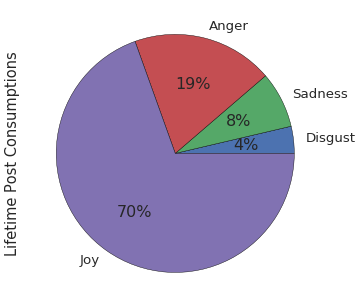

In [42]:
display(tones)

#### Now let's look at the same statistics as a bar chart.

It is the same line of code. Use the `Edit Metadata` button to see how PixieDust knows to show us a bar chart. If you don't have a button use the menu and select `View > Cell Toolbar > Edit Metadata`.

A bar chart is better at showing more information. We added `Cluster By: Type` so we already see numbers for posts and articles. Notice what the chart tells you. *Joy* seems to be the dominant emotion. Click on `Options` and try this:

* Change the aggregation to `AVG`.

What emotion leads to higher average consumption?



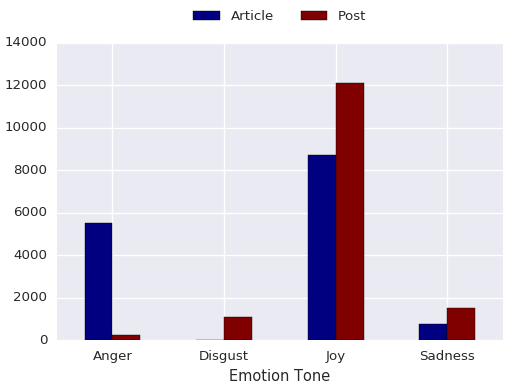

In [43]:
display(tones)

#### Now let's look at the entities that were detected by Natural Language Understanding.

The following bar chart shows the entities that were detected. This time we are stacking negative feedback and "likes" to get a picture of the kind of feedback the entities were getting. We chose a horizontal, stacked bar chart with descending values for a little variety.

* Try a different renderer and see what you get.


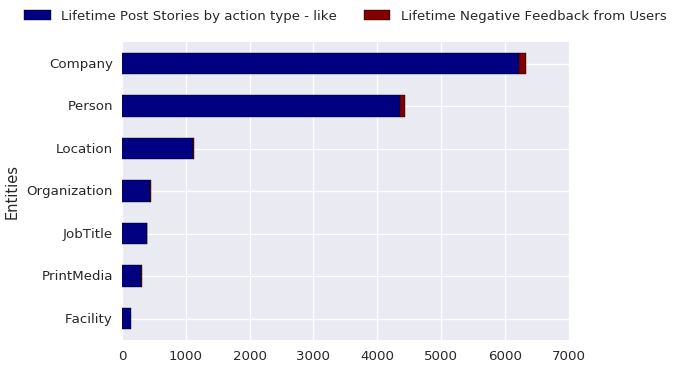

In [44]:
display(entities)

#### Next we look at the keywords detected by Natural Language Understanding

This time we are using the bokeh renderer for a different look. The renderers have different capabilities.

In [45]:
display(keywords)

#### Now let's take a look at what Visual Recognition can show us.

See how the images influenced the metrics. We've used visual recognition to identify a class and a type hierarchy for each image. We've also captured the top recognized color for each image. Our sample data doesn't have a significant number of data points, but these three charts demonstrate how you could:

1. Recognize image classes that correlate to higher average post consumption.
1. Add a type hierarchy for a higher level abstraction or to add grouping/stacking to the class data.
1. Determine if image color correlates to user reactions.

Visual recognition makes it surprisingly easy to do all of the above. Of course, you can easily try different metrics as you experiment. If you are not convinced that you should add ultramarine robot pictures to all of your articles, then you might want to do some research with a better data sample.

In [46]:
display(df_pic_keywords)

In [47]:
display(df_pic_keywords)

In [48]:
display(df_pic_keywords)

# More Info.
For more information about PixieDust, check out the following:
* PixieDust Documentation: https://ibm-cds-labs.github.io/pixiedust/index.html
* PixieDust GitHub Repo: https://github.com/ibm-cds-labs/pixiedust

Visit the Watson Accelerators portal to see more live patterns in action:
* Watson Accelerators: http://www.watsonaccelerators.com 